<a href="https://colab.research.google.com/github/jimtoberfest/MotoGP_PowerRankings/blob/main/MotoGP_MultiELO_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+git://github.com/djcunningham0/multielo.git

  Cloning git://github.com/djcunningham0/multielo.git to /tmp/pip-req-build-iman6jll
  Running command git clone -q git://github.com/djcunningham0/multielo.git /tmp/pip-req-build-iman6jll


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
import itertools
from itertools import permutations

from multielo import MultiElo, Player, Tracker

import math


# %matplotlib notebook


# RESETS ANY POTENTIAL RUNTIME ISSUES WITH MATPLOTLIB
%matplotlib inline
plt.close('all')

In [ ]:
path = '/content/drive/MyDrive/'
file = 'MotoGP_raw_data_1.xlsx'

data = pd.read_excel(path + file)

#Functions

In [ ]:
def seed_it(df_column):
  primary_list = list(df_column.unique())

  start_values = []
  for i in range(len(primary_list)):
    s_seed = 1000 + (1 if np.random.random() < 0.5 else -1)
    start_values.append(s_seed)

  return dict(zip(primary_list, start_values))

# Cleaning

In [ ]:
df = data.copy()

In [ ]:
df.columns= df.columns.str.strip().str.lower()
df.columns = [c.replace(".", "") for c in df.columns]
df.drop([2340], inplace=True)  #remove cancelled Silverstone race
df = df.fillna(0)
df = df.replace(['nan', 'None'], 0)
df.reset_index(drop=True,inplace=True)

In [ ]:
df.tail()

,race_num,track,season,pos,points,num,rider,nation,team,bike,kph,time_gap,laps_before_out
3587,18,valencia,2021,16,0,12.0,Maverick VIÑALES,SPA,Aprilia Racing Team Gresini,Aprilia,156.0,19.815,0
3588,18,valencia,2021,17,0,10.0,Luca MARINI,ITA,SKY VR46 Avintia,Ducati,155.4,28.86,0
3589,18,valencia,2021,18,0,9.0,Danilo PETRUCCI,ITA,Tech 3 KTM Factory Racing,KTM,155.2,32.169,0
3590,18,valencia,2021,0,0,42.0,Alex RINS,SPA,Team SUZUKI ECSTAR,Suzuki,156.5,17 Laps,17
3591,18,valencia,2021,0,0,30.0,Takaaki NAKAGAMI,JPN,LCR Honda IDEMITSU,Honda,153.8,23 La,23


#Feature Engineering

In [ ]:
df['pos_calcd'] =  df.groupby(['race_num', 'track','season'])['pos'].transform(lambda x: pd.Series(range(1, len(x)+1), index=x.index))
df['pos_c_minus_1'] = df['pos_calcd'].shift(-1)

In [ ]:
factory_list = ['Yamaha Factory Racing', 'Repsol Honda Team','Movistar Yamaha MotoGP','Team Suzuki MotoGP','Team SUZUKI ECSTAR','Aprilia Racing Team Gresini','Yamaha Factory Racing Team','Yamalube Yamaha Factory Racing',
                'Red Bull KTM Factory Racing','Red Bull KTM Factory Racing','Mission Winnow Ducati', 'Monster Energy Yamaha MotoGP','Aprilia Factory Racing', 'Team HRC', 'Aprilia Racing Team', 'Ducati Team']

In [ ]:
df['bike_calcd'] = df.apply(lambda x:  str(x['bike']) + '_sat' if x['team'] not in factory_list else x['bike'], axis = 1)
df['rider_bike'] = df['rider'] + '_' + df['bike_calcd']
df['track_bike'] = df['track'] + '_' + df['bike_calcd']
df['track_bike_rider'] = df['track_bike'] + '_' + df['rider']

In [ ]:
df.head(2)

,race_num,track,season,pos,points,num,rider,nation,team,bike,kph,time_gap,laps_before_out,pos_calcd,pos_c_minus_1,bike_calcd,rider_bike,track_bike,track_bike_rider
0,1,losail,2013,1,25,99.0,Jorge LORENZO,SPA,Yamaha Factory Racing,Yamaha,166.4,42'39.802,0,1,2.0,Yamaha,Jorge LORENZO_Yamaha,losail_Yamaha,losail_Yamaha_Jorge LORENZO
1,1,losail,2013,2,20,46.0,Valentino ROSSI,ITA,Yamaha Factory Racing,Yamaha,166.0,5.99,0,2,3.0,Yamaha,Valentino ROSSI_Yamaha,losail_Yamaha,losail_Yamaha_Valentino ROSSI


In [ ]:
year_list = list(df['season'].unique())
# year_list.pop(-1)
year_list

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

# Initial Seeding

In [ ]:
rider_bikes = seed_it(df['rider_bike'])
# rider_bikes

# ELO Runs

### Set initial parameters for ELO runs

In [ ]:
elo_custom = MultiElo(k_value=24, d_value=400, score_function_base=1.2)

### Create empty DF to hold results

In [ ]:

df_bulk_columns = ['track', 'season', 'pos_calcd', 'rider_bike', 'curr_elo',
       'pre_race_pred', 'new_elo']

df_bulk = pd.DataFrame(columns = df_bulk_columns)

In [ ]:
df_bulk

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo


### THE LOOP

In [ ]:
# Loop Should be HERE for Production

'''
  Example Code for looping thru...etl_params_ondeck is an empty df that everything gets joined into
  
  frames = [etl_params_ondeck, df]

  etl_params_ondeck = pd.concat(frames, ignore_index=True)

'''
for year in range(len(year_list)):


  # year = 2013

  df_race_count = df[df['season'] == year_list[year]]

  for j in range(df_race_count['race_num'].max()):
    # print(j)
    dfr = df[(df['race_num'] == j+1) & (df['season'] == year_list[year])]  #j then i for the looping
    dfr = dfr[['track', 'season', 'pos_calcd','rider_bike']]
    dfr['curr_elo'] = df['rider_bike'] .apply(lambda x: rider_bikes[x])
    # dfr.head(5)
    
    elo_0 = list(dfr['curr_elo'])
    win_probability = elo_custom.simulate_win_probabilities(elo_0)
    predicted_place_pre_race = []
    for k in range(len(win_probability)):
      max_index_col = np.argmax(win_probability[k], axis=0)
      predicted_place_pre_race.append(max_index_col)

    dfr['pre_race_pred'] = predicted_place_pre_race
    
    #Get new ratings and add to df
    elo_new = elo_custom.get_new_ratings(elo_0)
    dfr['new_elo'] = elo_new.tolist()

    # push elo_new to rider_bikes dict

    for u in range(len(dfr['new_elo'])):
      name = dfr.iloc[u]['rider_bike']
      score = dfr.iloc[u]['new_elo']
      rider_bikes[name] = score

    frames =[df_bulk, dfr]
    df_bulk = pd.concat(frames, ignore_index=True)
    # End Inner Loop


  # Partial PowerRank Reset Post-Season
  for k, v in rider_bikes.items():
      rider_bikes[k] = v + (((v - 1000) / 2)*-1)
  #End Outer Loop


In [ ]:
df_bulk

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo
0,losail,2013,1,Jorge LORENZO_Yamaha,1001,7,1075.667611
1,losail,2013,2,Valentino ROSSI_Yamaha,999,17,1057.265685
2,losail,2013,3,Marc MARQUEZ_Honda,999,19,1043.482286
3,losail,2013,4,Dani PEDROSA_Honda,999,16,1031.996121
4,losail,2013,5,Cal CRUTCHLOW_Yamaha_sat,1001,3,1024.286162
...,...,...,...,...,...,...,...
7179,valencia,2021,16,Maverick VIÑALES_Aprilia,958.736,16,942.169302
7180,valencia,2021,17,Luca MARINI_Ducati_sat,864.381,19,852.226751
7181,valencia,2021,18,Danilo PETRUCCI_KTM_sat,838.339,19,826.767830
7182,valencia,2021,19,Alex RINS_Suzuki,1059.26,8,1034.390307


In [ ]:
df_bulk.tail(27)

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo
7157,portimao,2021,16,Maverick VIÑALES_Aprilia,975.533,17,958.736026
7158,portimao,2021,17,Franco MORBIDELLI_Yamaha,950.575,18,934.281367
7159,portimao,2021,18,Miguel OLIVEIRA_KTM,980.945,14,961.972291
7160,portimao,2021,19,Iker LECUONA_KTM_sat,846.063,21,834.216736
7161,portimao,2021,20,Fabio QUARTARARO_Yamaha,1439.99,0,1399.000728
7162,portimao,2021,21,Aleix ESPARGARO_Aprilia,1004.69,11,982.504484
7163,portimao,2021,22,Danilo PETRUCCI_KTM_sat,851.975,21,838.338819
7164,valencia,2021,1,Francesco BAGNAIA_Ducati_sat,1306.64,0,1353.895661
7165,valencia,2021,2,Jorge MARTIN_Ducati_sat,1030.2,10,1076.573206
7166,valencia,2021,3,Jack MILLER_Ducati_sat,1173.62,4,1199.955330


In [ ]:
df_final_riderb_ranks = df_bulk.groupby(['season', 'rider_bike'])['new_elo'].max().reset_index().sort_values('new_elo', ascending=False)
print(len(df_final_riderb_ranks))
df_final_riderb_ranks.head(50)

290


,season,rider_bike,new_elo
219,2019,Marc MARQUEZ_Honda,2126.143353
83,2015,Jorge LORENZO_Yamaha,1952.532696
102,2015,Valentino ROSSI_Yamaha,1938.457306
53,2014,Marc MARQUEZ_Honda,1928.107308
187,2018,Marc MARQUEZ_Honda,1865.138276
156,2017,Marc MARQUEZ_Honda,1760.529026
122,2016,Marc MARQUEZ_Honda,1721.903522
88,2015,Marc MARQUEZ_Honda,1719.831310
49,2014,Jorge LORENZO_Yamaha,1712.605773
19,2013,Jorge LORENZO_Yamaha,1692.938736


# Explore some results, rank riders

In [ ]:
dfrb = pd.DataFrame(rider_bikes.items(), columns=['rider_bike', 'PowerRank']).sort_values('PowerRank', ascending=False)
dfrbA = dfrb[(dfrb['PowerRank'] != 1001.0) & (dfrb['PowerRank'] != 999.0) ]
print('MAX: ', dfrbA['PowerRank'].max())
print('MIN: ', dfrbA['PowerRank'].min())
dfrbA.reset_index(drop=True, inplace=True)
dfrbA.head(25)

MAX:  1199.0137796444767
MIN:  912.8624334906941


,rider_bike,PowerRank
0,Fabio QUARTARARO_Yamaha,1199.013780
1,Francesco BAGNAIA_Ducati_sat,1176.947830
2,Marc MARQUEZ_Honda,1157.946539
3,Joan MIR_Suzuki,1142.058847
4,Jack MILLER_Ducati_sat,1099.977665
5,Maverick VIÑALES_Yamaha,1057.989622
6,Johann ZARCO_Ducati_sat,1055.943449
7,Andrea DOVIZIOSO_Ducati,1053.080936
8,Jorge MARTIN_Ducati_sat,1038.286603
9,Pol ESPARGARO_KTM,1036.164415


In [ ]:
  # rider_bikes

In [ ]:
odds = 1 / (1 + (10**((dfrbA['PowerRank'][3]-dfrbA['PowerRank'][2])/400)))
odds

0.5228483036713658

# Correcting Function for each season

In [ ]:
chk_stp = []
contracted = []
unknowny = []

for i in range(100, 2500, 50):
  chk_stp.append(i)
  m = i + (((i - 1000) / 2)*-1)
  q = (i + ((((i - 1000)*float(.10))**float(1.39))*-1))
  q = q.real + q.imag
  unknowny.append(q)
  contracted.append(m)

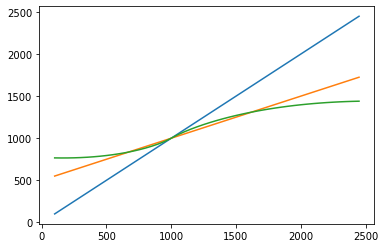

In [ ]:
plt.plot(chk_stp, chk_stp)
plt.plot(chk_stp, contracted)
plt.plot(chk_stp, unknowny)

In [ ]:
arr1 = np.array(chk_stp)
arr2 = np.array(contracted)
arr3 = np.array(unknowny)

In [ ]:
print(arr3.mean())
print(arr3.std())

1120.6136680690609
255.24577372769167


In [ ]:
print(arr2.mean())
print(arr2.std())

1137.5
346.3349775386059


In [ ]:
(500 * .10)**1.5

353.5533905932738

In [ ]:
(((1500)*.10)**1.5)


1837.1173070873836

In [ ]:
# Partial PowerRank Reset Post-Season

for k, v in rider_bikes.items():
    rider_bikes[k] = v + (((v - 1000) / 2)*-1)

In [ ]:
rider_bikes

{'Aleix ESPARGARO_ART_sat': 999.9072475241275,
 'Aleix ESPARGARO_Aprilia': 994.7968473728029,
 'Aleix ESPARGARO_Suzuki': 999.6915938859506,
 'Aleix ESPARGARO_Yamaha Forward_sat': 1000.0691198241987,
 'Alex DE ANGELIS_ART_sat': 999.2476346882275,
 'Alex DE ANGELIS_Ducati_sat': 999.9919855926041,
 'Alex DE ANGELIS_Yamaha Forward_sat': 999.8164292628761,
 'Alex LOWES_Yamaha_sat': 999.75683503432,
 'Alex MARQUEZ_Honda': 997.8738402433762,
 'Alex MARQUEZ_Honda_sat': 976.7258919040623,
 'Alex RINS_Suzuki': 1008.5975768713416,
 'Alvaro BAUTISTA_Aprilia': 999.220368372136,
 'Alvaro BAUTISTA_Ducati': 1000.9659435032893,
 'Alvaro BAUTISTA_Ducati_sat': 999.6212922994296,
 'Alvaro BAUTISTA_Honda_sat': 999.9683903460934,
 'Andrea DOVIZIOSO_Ducati': 1026.5404682094495,
 'Andrea DOVIZIOSO_Yamaha_sat': 983.6024046043731,
 'Andrea IANNONE_Aprilia': 991.0169768029646,
 'Andrea IANNONE_Ducati': 1001.2774367669492,
 'Andrea IANNONE_Ducati_sat': 999.9536880571785,
 'Andrea IANNONE_Suzuki': 1000.60050629862

# Further Exploration

In [ ]:
df_bulk.tail()

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo
7179,valencia,2021,16,Maverick VIÑALES_Aprilia,958.736,16,942.169302
7180,valencia,2021,17,Luca MARINI_Ducati_sat,864.381,19,852.226751
7181,valencia,2021,18,Danilo PETRUCCI_KTM_sat,838.339,19,826.767830
7182,valencia,2021,19,Alex RINS_Suzuki,1059.26,8,1034.390307
7183,valencia,2021,20,Takaaki NAKAGAMI_Honda_sat,929.403,17,911.613282


## Tentative Calcs

In [ ]:

# df_bulk.fillna(0, inplace=True)

# Create copy
df_detail = df_bulk.copy()

# Selection params

# df_detail = df_bulk[df_bulk['rider_bike'] == 'Valentino ROSSI_Yamaha' ].reset_index()

# dfd = df_detail[df_detail['season'] == 2015]

# dfd = df_detail[df_detail['pos_calcd'] == 1]
# dfd = df_detail[ (df_detail['pos_calcd'] == 1) & (df_detail['rider_bike'] != 'Marc MARQUEZ_Honda') & (df_detail['season'] != 2013)]
dfd = df_detail[(df_detail['season'] != 2013)]


# dfd = df_detail.copy()


# Features
dfd['pre_race_pred'] = dfd['pre_race_pred'] + 1
dfd['place_diff'] = (dfd['pre_race_pred'] + 0) - dfd['pos_calcd']
dfd['bool_winner_pred'] = dfd['place_diff'].apply(lambda x:  1 if x == 0 else 0)
dfd['abs_error'] = abs(dfd['place_diff'])


print( 'MEAN:', dfd['place_diff'].mean())
print( 'std:', dfd['place_diff'].std())
print('dfd len:', len(dfd))
print( 'count:', dfd['bool_winner_pred'].sum())
print( 'accuracy:', (dfd['bool_winner_pred'].sum() / len(dfd)))
print( 'acc - Marquez naive guess:', (dfd['bool_winner_pred'].sum() / len(dfd) - .44))
print(dfd['place_diff'].max())
dfd

MEAN: 2.6247631080227416
std: 7.238309058912314
dfd len: 6758
count: 252
accuracy: 0.03728913879846108
acc - Marquez naive guess: -0.4027108612015389
21


,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo,place_diff,bool_winner_pred,abs_error
426,losail,2014,1,Marc MARQUEZ_Honda,1328.79,1,1385.267375,0,1,0
427,losail,2014,2,Valentino ROSSI_Yamaha,1194.57,5,1241.151328,3,0,3
428,losail,2014,3,Dani PEDROSA_Honda,1294.49,1,1322.970120,-2,0,2
429,losail,2014,4,Aleix ESPARGARO_Yamaha Forward_sat,999.5,18,1033.314220,14,0,14
430,losail,2014,5,Andrea DOVIZIOSO_Ducati,1009.97,16,1033.855509,11,0,11
...,...,...,...,...,...,...,...,...,...,...
7179,valencia,2021,16,Maverick VIÑALES_Aprilia,958.736,17,942.169302,1,0,1
7180,valencia,2021,17,Luca MARINI_Ducati_sat,864.381,20,852.226751,3,0,3
7181,valencia,2021,18,Danilo PETRUCCI_KTM_sat,838.339,20,826.767830,2,0,2
7182,valencia,2021,19,Alex RINS_Suzuki,1059.26,9,1034.390307,-10,0,10


In [ ]:
dfd[dfd['place_diff'] > 30]

dfd.fillna(0, inplace=True)

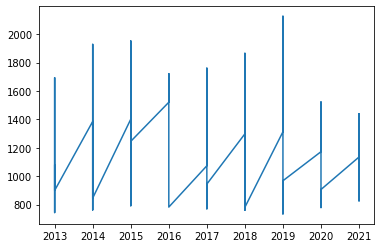

In [ ]:
  plt.plot(df_detail['season'], df_detail['new_elo'])

(array([  43.,   91.,  188.,  383., 4738.,  809.,  440.,   66.]),
 array([-23. , -17.5, -12. ,  -6.5,  -1. ,   4.5,  10. ,  15.5,  21. ]),
 <a list of 8 Patch objects>)

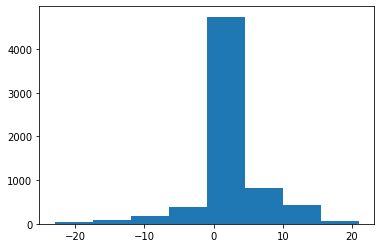

In [ ]:
plt.hist(dfd['place_diff'], bins=8)

In [ ]:
from sklearn import linear_model

# Initialize model
regression_model = linear_model.LinearRegression()

# Train the model using the mtcars data
regression_model.fit(X = pd.DataFrame(dfd['pre_race_pred']), 
                     y = dfd['pos_calcd'])

# Check trained model y-intercept
print(regression_model.intercept_)

# Check trained model coefficients
print(regression_model.coef_)

9.74303589765098
[-0.00358171]


In [ ]:
regression_model.score(X = pd.DataFrame(dfd['pre_race_pred']), 
                     y = dfd['pos_calcd'])

0.4130734706157616

In [ ]:
train_prediction = regression_model.predict(X = pd.DataFrame(dfd["pre_race_pred"]))

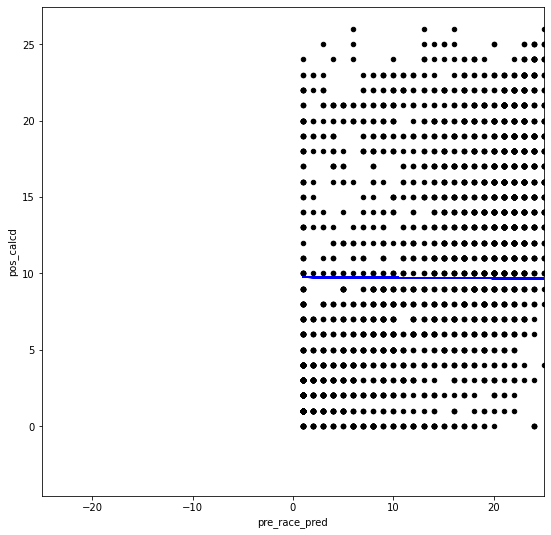

In [ ]:

dfd.plot(kind="scatter",
           x="pre_race_pred",
           y="pos_calcd",
           figsize=(9,9),
           color="black",
           xlim = (-25,25))

# Plot regression line
plt.plot(dfd["pre_race_pred"],      # Explanitory variable
         train_prediction,  # Predicted values
         color="blue");

In [ ]:
dfd.head(10)

,track,season,pos_calcd,rider_bike,curr_elo,pre_race_pred,new_elo,place_diff,bool_winner_pred,abs_error
426,losail,2014,1,Marc MARQUEZ_Honda,1328.785758,1,1385.267375,0,1,0
427,losail,2014,2,Valentino ROSSI_Yamaha,1194.569115,5,1241.151328,3,0,3
428,losail,2014,3,Dani PEDROSA_Honda,1294.493898,1,1322.970120,-2,0,2
429,losail,2014,4,Aleix ESPARGARO_Yamaha Forward_sat,999.500000,18,1033.314220,14,0,14
430,losail,2014,5,Andrea DOVIZIOSO_Ducati,1009.970031,16,1033.855509,11,0,11
431,losail,2014,6,Cal CRUTCHLOW_Ducati,1000.500000,19,1017.254008,13,0,13
432,losail,2014,7,Scott REDDING_Honda_sat,999.500000,20,1009.878233,13,0,13
433,losail,2014,8,Nicky HAYDEN_Honda_sat,1000.500000,17,1005.450169,9,0,9
434,losail,2014,9,Colin EDWARDS_Yamaha Forward_sat,1000.500000,18,1000.979017,9,0,9
435,losail,2014,10,Andrea IANNONE_Ducati_sat,932.954891,23,933.844594,13,0,13


In [ ]:
dfd['pos_calcd'] = pd.to_numeric(dfd['pos_calcd'], errors = 'coerce')
dfd['abs_error'] = pd.to_numeric(dfd['abs_error'], errors = 'coerce')

dfd_mae = dfd.groupby(['pos_calcd'])['abs_error'].mean().reset_index()
dfd_mae_B = dfd.groupby(['pos_calcd'])['abs_error'].std().reset_index()
# dfd_mae = dfd_mae.merge(dfd_mae_B,suffixes='_x')
# dfd_mae

In [ ]:
dfd_m = dfd_mae.merge(dfd_mae_B, left_on='pos_calcd', right_on='pos_calcd',
          suffixes=('_left', '_right'))
dfd_m.rename(columns={'abs_error_left': 'MAE', 'abs_error_right': 'std'}, inplace=True)

In [ ]:
dfd_m

,pos_calcd,MAE,std
0,0,0.000000,0.000000
1,1,3.050000,4.849275
2,2,4.528571,4.895223
3,3,5.028571,5.438926
4,4,5.242857,5.067702
5,5,6.100000,4.871441
6,6,6.585714,4.772502
7,7,7.142857,4.889530
8,8,6.928571,4.511604
9,9,7.164286,4.637369
